<a href="https://colab.research.google.com/github/m-adil172000/BTP/blob/main/Image_segmentation_using_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


In [ ]:
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/BTP/Train/images"):
  for img_path in glob.glob(os.path.join(directory_path, "*.png")):
    print(img_path)
    img = cv2.imread(img_path, 1)
    train_images.append(img)

train_images = np.array(train_images)

/content/drive/MyDrive/BTP/Train/images/4.png
/content/drive/MyDrive/BTP/Train/images/8.png
/content/drive/MyDrive/BTP/Train/images/12.png
/content/drive/MyDrive/BTP/Train/images/16.png
/content/drive/MyDrive/BTP/Train/images/20.png
/content/drive/MyDrive/BTP/Train/images/24.png
/content/drive/MyDrive/BTP/Train/images/28.png
/content/drive/MyDrive/BTP/Train/images/32.png
/content/drive/MyDrive/BTP/Train/images/36.png
/content/drive/MyDrive/BTP/Train/images/40.png
/content/drive/MyDrive/BTP/Train/images/44.png
/content/drive/MyDrive/BTP/Train/images/48.png
/content/drive/MyDrive/BTP/Train/images/52.png
/content/drive/MyDrive/BTP/Train/images/56.png
/content/drive/MyDrive/BTP/Train/images/60.png
/content/drive/MyDrive/BTP/Train/images/64.png
/content/drive/MyDrive/BTP/Train/images/68.png
/content/drive/MyDrive/BTP/Train/images/72.png
/content/drive/MyDrive/BTP/Train/images/0.png
/content/drive/MyDrive/BTP/Train/images/1.png
/content/drive/MyDrive/BTP/Train/images/3.png
/content/drive/MyD

In [ ]:
train_masks = []

for directory_path in glob.glob("/content/drive/MyDrive/BTP/Train/masks"):
  for img_path in glob.glob(os.path.join(directory_path, "*.png")):
    print(img_path)
    img = cv2.imread(img_path, 1)
    train_masks.append(img)

train_masks = np.array(train_masks)

/content/drive/MyDrive/BTP/Train/masks/m8.png
/content/drive/MyDrive/BTP/Train/masks/m12.png
/content/drive/MyDrive/BTP/Train/masks/m0.png
/content/drive/MyDrive/BTP/Train/masks/m16.png
/content/drive/MyDrive/BTP/Train/masks/m56.png
/content/drive/MyDrive/BTP/Train/masks/m20.png
/content/drive/MyDrive/BTP/Train/masks/m52.png
/content/drive/MyDrive/BTP/Train/masks/m60.png
/content/drive/MyDrive/BTP/Train/masks/m36.png
/content/drive/MyDrive/BTP/Train/masks/m24.png
/content/drive/MyDrive/BTP/Train/masks/m28.png
/content/drive/MyDrive/BTP/Train/masks/m68.png
/content/drive/MyDrive/BTP/Train/masks/m40.png
/content/drive/MyDrive/BTP/Train/masks/m48.png
/content/drive/MyDrive/BTP/Train/masks/m44.png
/content/drive/MyDrive/BTP/Train/masks/m32.png
/content/drive/MyDrive/BTP/Train/masks/m4.png
/content/drive/MyDrive/BTP/Train/masks/m72.png
/content/drive/MyDrive/BTP/Train/masks/m64.png
/content/drive/MyDrive/BTP/Train/masks/m1.png
/content/drive/MyDrive/BTP/Train/masks/m3.png
/content/drive/MyD

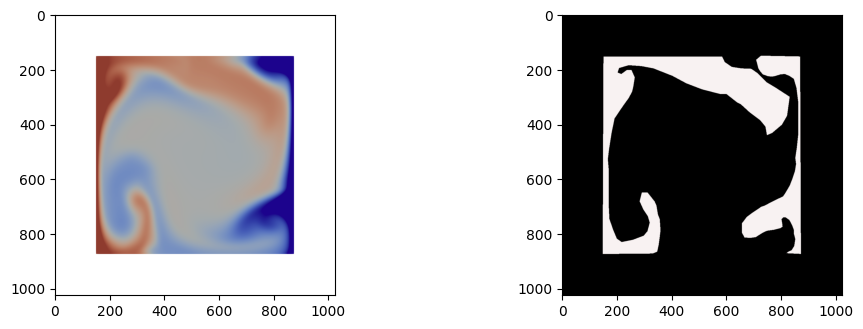

In [ ]:
import random
img_number = random.randint(0, len(train_images)-1)
img = train_images[img_number]
mask = train_masks[img_number]

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(mask)
plt.show()

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/BTP/Train/images/*.png")
image_names.sort()
images = [cv2.imread(image,1) for image in image_names]
image_dataset = np.array(images)

In [ ]:
mask_names = glob.glob("/content/drive/MyDrive/BTP/Train/masks/*.png")
mask_names.sort()
masks = [cv2.imread(mask,1) for mask in mask_names]
masks_dataset = np.array(masks)

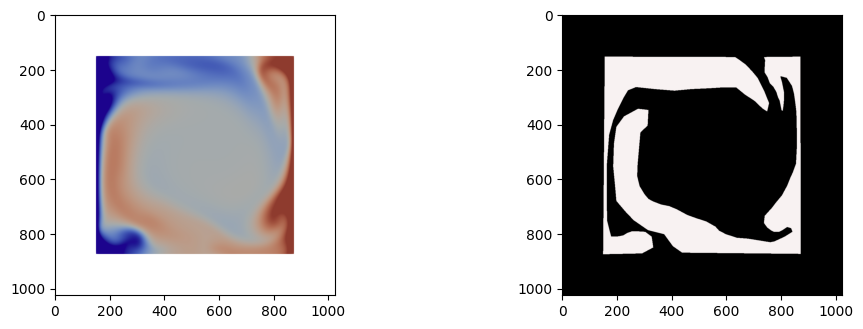

In [ ]:
import random
img_number = random.randint(0, len(train_images)-1)
img = image_dataset[img_number]
mask = masks_dataset[img_number]

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(mask)
plt.show()

In [ ]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
masks_dataset = masks_dataset /255.  #Pixel values will be 0 or 1

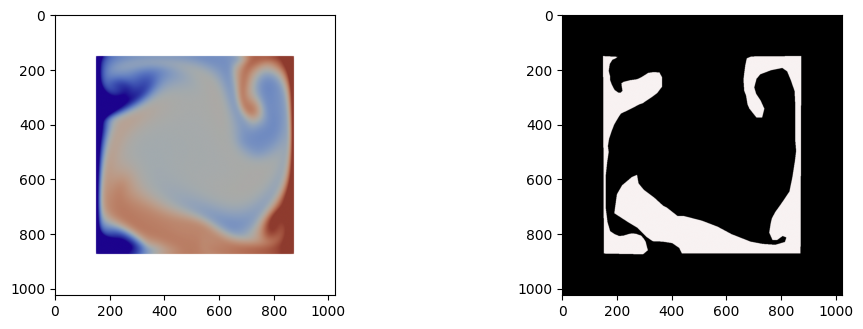

In [ ]:
import random
img_number = random.randint(0, len(train_images)-1)
img = image_dataset[img_number]
mask = masks_dataset[img_number]

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(mask)
plt.show()

In [ ]:
print(image_dataset.shape)

(76, 1024, 1024, 3)


In [ ]:
print(masks_dataset.shape)

(76, 1024, 1024, 3)


In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate


def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling
def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


#Decoder block --skip features gets input from encoder for concatenation
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 3, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [ ]:
img_dataset = image_dataset[45:]
msk_dataset = masks_dataset[45:]
print(img_dataset.shape)
print(msk_dataset.shape)

(31, 1024, 1024, 3)
(31, 1024, 1024, 3)


In [ ]:
NUM_IMAGES = img_dataset.shape[0]
IMG_HEIGHT = img_dataset.shape[1]
IMG_WIDTH  = img_dataset.shape[2]
IMG_CHANNELS = img_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
print(input_shape)

(1024, 1024, 3)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(img_dataset, msk_dataset, test_size = 0.20, random_state = 42)

In [ ]:
model = build_unet(input_shape, n_classes=3)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

softmax
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 64)       1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 1024, 64)       256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 1024, 1024, 64)       0         ['batch_normalizat

In [ ]:
history = model.fit(X_train[:], y_train,
                    batch_size = 1,
                    verbose=1,
                    epochs=15,
                    shuffle=False)


Epoch 1/15
24/24 [==============================] - 22s 909ms/step - loss: 0.0714 - accuracy: 0.7208
Epoch 2/15
24/24 [==============================] - 22s 929ms/step - loss: 0.0716 - accuracy: 0.7575
Epoch 3/15
24/24 [==============================] - 23s 957ms/step - loss: 0.0711 - accuracy: 0.8503
Epoch 4/15
24/24 [==============================] - 23s 975ms/step - loss: 0.0713 - accuracy: 0.8693
Epoch 5/15
24/24 [==============================] - 24s 991ms/step - loss: 0.0702 - accuracy: 0.5693
Epoch 6/15
24/24 [==============================] - 24s 1s/step - loss: 0.0714 - accuracy: 0.5595
Epoch 7/15
24/24 [==============================] - 24s 1000ms/step - loss: 0.0703 - accuracy: 0.5002
Epoch 8/15
24/24 [==============================] - 24s 995ms/step - loss: 0.0707 - accuracy: 0.4456
Epoch 9/15
24/24 [==============================] - 24s 992ms/step - loss: 0.0700 - accuracy: 0.4462
Epoch 10/15
24/24 [==============================] - 24s 993ms/step - loss: 0.0699 - accuracy

In [ ]:
test_names = "/content/drive/MyDrive/BTP/Test/T.0006.png"
tests = cv2.imread(test_names,1)
test_dataset = np.array(tests)

In [ ]:
image_names = glob.glob("/content/drive/MyDrive/BTP/Test/*.png")
image_names.sort()
images = [cv2.imread(image,1) for image in image_names]
test_dataset = np.array(images)
test_dataset = test_dataset/255

In [ ]:
y_pred = model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

1/1 [==============================] - 0s 113ms/step


(1, 1024, 1024, 3)
1/1 [==============================] - 0s 25ms/step
(1024, 1024)


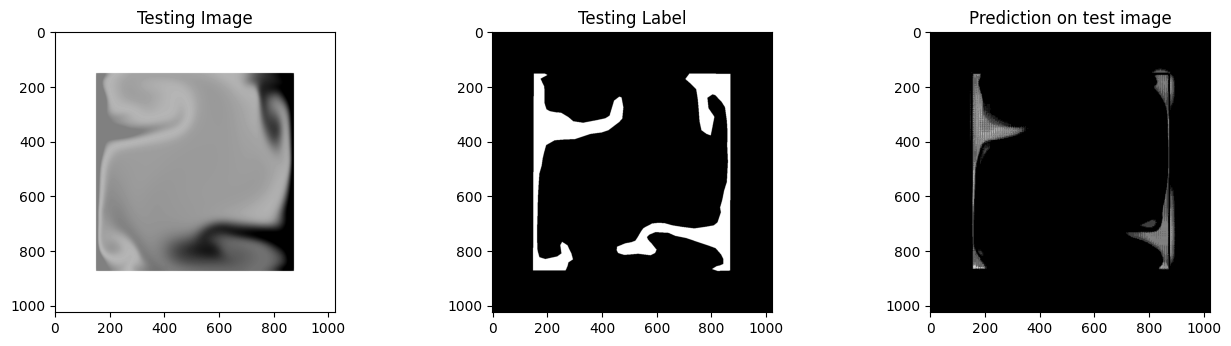

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction,cmap='gray' )

plt.show()

(1, 1024, 1024, 3)
1/1 [==============================] - 0s 33ms/step
(1024, 1024)


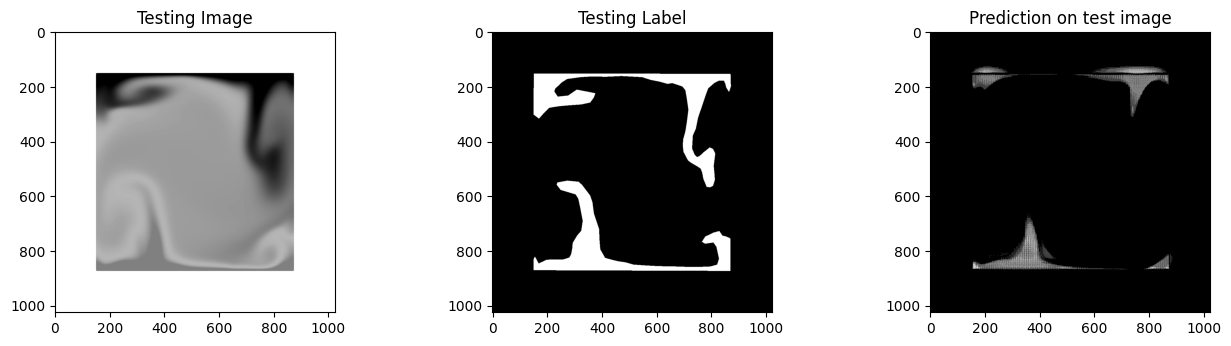

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

(1, 1024, 1024, 3)
1/1 [==============================] - 0s 35ms/step
(1024, 1024)


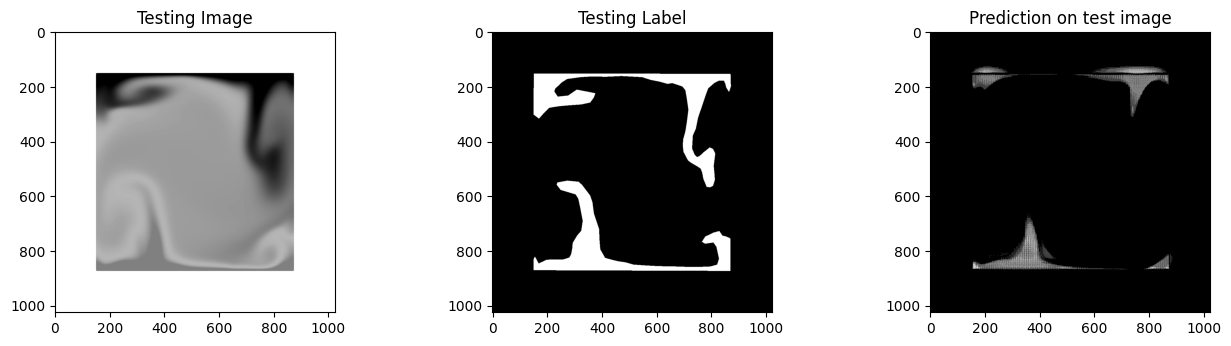

In [ ]:

threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

(1, 1024, 1024, 3)
1/1 [==============================] - 0s 31ms/step
(1024, 1024)


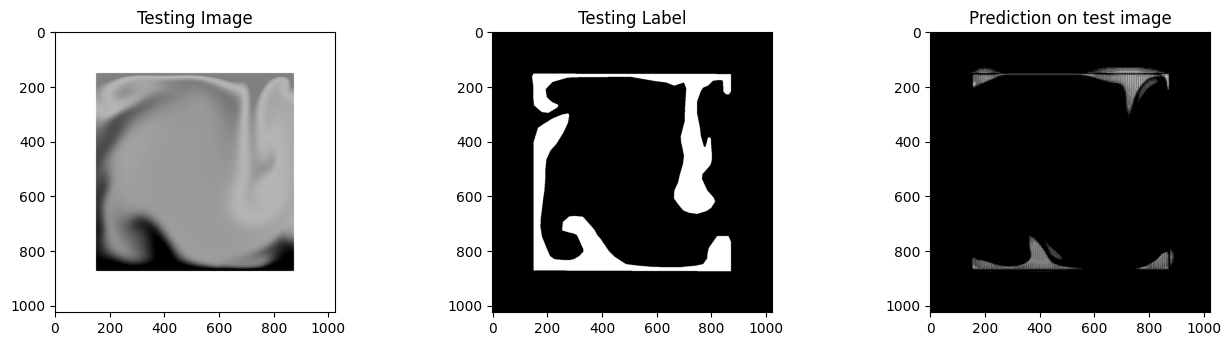

In [ ]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

(1,)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type NoneType).